In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import requests
import locale
locale.setlocale(locale.LC_ALL, '');

In [2]:
def get_data(stn_id='', start_date=None, end_date=None):
    if stn_id.casefold() == 'troll'.casefold():
        stn = 'kldata/nationalnr=99990/type=504'
    elif stn_id.casefold() == 'TAF'.casefold():
        stn = 'kldata/nationalnr=92100/type=504'
    else:
        raise ValueError('get_data(stn_id, start_date, end_date):\n stn_id is required and must match ''Troll'' or ''TAF'' (case insensitive)')
    if (start_date is None and end_date is None):
        d_start = pd.Timestamp.now().normalize() - pd.offsets.MonthEnd() - pd.offsets.MonthBegin()
        d_end = pd.Timestamp.now().normalize() - pd.offsets.MonthBegin() - pd.Timedelta(milliseconds=1)
    elif (start_date is not None and end_date is not None):
        try:
            d_start = pd.to_datetime(start_date)
            d_end = pd.to_datetime(end_date)
        except:
            raise ValueError('get_data(stn_id, start_date, end_date):\n start_date and end_date must convert to datetime with pd.to_datetime()')
        else:
            if d_start >= d_end or d_start >= pd.Timestamp.now():
                raise ValueError('get_data(stn_id, start_date, end_date):\n start_date must be before end_date and current time')
    else:
        if end_date is None:
            try:
                d_start = pd.to_datetime(start_date)
            except:
                raise ValueError('get_data(stn_id, start_date):\n start_date must convert to datetime with pd.to_datetime()')
            else:
                if d_start >= pd.Timestamp.now():
                    raise ValueError('get_data(stn_id, start_date):\n start_date must be before current time')
            d_end = pd.Timestamp.now()
        elif start_date is None:
            try:
                d_end = pd.to_datetime(end_date)
            except:
                raise ValueError('get_data(stn_id, end_date=''date_str''):\n end_date must convert to datetime with pd.to_datetime()')
            else:
                if d_end >= pd.Timestamp.now():
                    raise ValueError('get_data(stn_id, end_date=''date_str''):\n end_date must be before current time')
            d_start = d_end - pd.Timedelta(weeks=4)
    
    var = 'DD0_6,FF0_6,FG0_6,TA0_0,DD0_0,FF0_0,FG0_0'
    url = 'https://api.npolar.no/weather/troll/'
    parameters = {
        'q': '',
        'format': 'json',
        'filter-station_id': stn,
        'filter-measured': d_start.strftime('%Y-%m-%dT%H:%M:%S')+'..'+d_end.strftime('%Y-%m-%dT%H:%M:%S'),
        'fields': 'measured,'+var,
        'limit': '14400',
        'start': '0'
    }
    
    r = requests.get(url, params=parameters)
            
    data = pd.read_json(r.text,orient='records')
    d = pd.DataFrame(data['feed']['entries'])
    d.measured = pd.to_datetime(d.measured)
    d = d.set_index('measured')
    
    while data['feed']['list']['next']:
        r = requests.get(data['feed']['list']['next'])
        data = pd.read_json(r.text,orient='records')
        d1 = pd.DataFrame(data['feed']['entries'])
        d1.measured = pd.to_datetime(d1.measured)
        d1 = d1.set_index('measured')
        d = pd.concat([d,d1],sort=False)
    d[d==-99.9] = np.nan

    d.rename(columns={'FF0_6': 'FF0_0', 'FG0_6': 'FG0_0', 'DD0_6': 'DD0_0'}, inplace=True)
    d = d.sort_index()
    
    return d

In [3]:
def resample_df(d):
    d['u'] = -d.FF0_0 * np.sin(np.pi * d.DD0_0 / 180)
    d['v'] = -d.FF0_0 * np.cos(np.pi * d.DD0_0 / 180)
    
    d_avg = d.resample('1H').mean()
    d_avg['sp'] = np.sqrt(d_avg.u*d_avg.u + d_avg.v*d_avg.v)
    d_avg['dir'] = 180 + (180/np.pi) * np.arctan2(d_avg.u,d_avg.v)
    
    d_avg['maxG'] = np.nan
    d_avg['maxG'] = d.FG0_0.resample('6H').max()

    return d_avg

In [4]:
def plot_data2(dfTroll, dfTAF, lang='eng'):
    fs = 20 #font size, top title fs*1.25
    if (lang!='nor' and lang!='eng'):
        raise ValueError('plot_data(dfTroll, dfTAF, lang):\n lang must be ''nor'' or ''eng'', case sensitive')
    cTroll = 'peru'
    cTAF = 'lightskyblue'
    
    loc     = {'nor': 'nb_NO', 'eng': 'en_US'}
    Tlabel  = {'nor': 'lufttemperatur', 'eng': 'air temperature'}
    spLabel = {'nor': 'vindhastighet', 'eng': 'wind speed'}
    gLabel  = {'nor': 'høyeste vindkast', 'eng': 'highest gust'}
    xLabel  = {'nor': 'Dato', 'eng': 'Date'}
    yLabel1 = {'nor': 'Temperatur (°C)', 'eng': 'Temperature (°C)'}
    yLabel2 = {'nor': 'Vindhastighet (m/s)', 'eng': 'Wind speed (m/s)'}
    title   = {'nor': 'Vær på Troll ', 'eng': 'Weather at Troll '}
    weather = {'nor': 'vær_', 'eng': 'weather_'}
    origLoc = locale.getlocale()
    locale.setlocale(locale.LC_ALL, loc[lang])
    
    f, (a1, a2) = plt.subplots(2, 1, figsize=(16,14), sharex=True)

    dfTroll = resample_df(dfTroll)
    dfTAF = resample_df(dfTAF)
    
    a1.plot(dfTroll.index+pd.DateOffset(minutes=30), dfTroll.TA0_0, color=cTroll, label='Troll '+Tlabel[lang], linewidth='2')
    a1.plot(dfTAF.index+pd.DateOffset(minutes=30), dfTAF.TA0_0, color=cTAF, label='TAF '+Tlabel[lang], linewidth='2')
    a2.plot(dfTroll.index+pd.DateOffset(minutes=30), dfTroll.sp, color=cTroll, label='Troll '+spLabel[lang], linewidth='2')
    a2.plot(dfTroll.index+pd.DateOffset(hours=3), dfTroll.maxG, '.', color=cTroll, label='Troll '+gLabel[lang], markersize=8)
    a2.plot(dfTAF.index+pd.DateOffset(minutes=30), dfTAF.sp, color=cTAF, label='TAF '+spLabel[lang], linewidth='2')
    a2.plot(dfTAF.index+pd.DateOffset(hours=3), dfTAF.maxG, '.', color=cTAF, label='TAF '+gLabel[lang], markersize=8)
    
    
    s = min(dfTroll.index.min(), dfTAF.index.min())
    e = max(dfTroll.index.max(), dfTAF.index.max())
    length = e - s
    saveFile = 'TrollTAF_' + weather[lang] + s.strftime('%Y-%m-%d_') + e.strftime('%Y-%m-%d.png')
    if length > pd.Timedelta(days=183):
        majLoc = 'mdates.MonthLocator(interval=1, bymonthday=1)'
        minLoc = 'mdates.DayLocator(bymonthday=[11, 21])'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=62):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 15])'
        minLoc = 'mdates.DayLocator(bymonthday=np.arange(3, 31, 2))'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=41):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 11, 21])'
        minLoc = 'mdates.DayLocator(interval=1)'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=21):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 6, 11, 16, 21, 26])'
        minLoc = 'mdates.DayLocator(interval=1)'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(e.year)
                saveFile = 'TrollTAF_' + weather[lang] + s.strftime('%Y-%m.png')
            else:
                if s.month==e.month:
                    figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
                else:
                    figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                             str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=7):
        majLoc = 'mdates.DayLocator(bymonthday=np.arange(1, 32))'
        minLoc = 'mdates.HourLocator(byhour=[0, 6, 12, 18])'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=3):
        majLoc = 'mdates.DayLocator()'
        minLoc = 'mdates.HourLocator(byhour=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    else:
        majLoc = 'mdates.HourLocator(byhour=[0, 6, 12, 18, 24])'
        minLoc = 'mdates.HourLocator()'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    
    
    a1.minorticks_on()
    a1.tick_params(labelbottom=True)
    a1.tick_params(which='minor', length=0)
    a1.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a1.grid(color='k', linestyle='--')
    a1.tick_params(axis='both', labelsize=fs)
    a1.set_ylabel(yLabel1[lang], fontsize=fs)
    a1.legend(fontsize=fs)
    
    a2.minorticks_on()
    a2.xaxis.set_major_locator(eval(majLoc))
    a2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(eval(majLoc)))
    a2.xaxis.set_minor_locator(eval(minLoc))
    a2.tick_params(which='minor', length=0)
    a2.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a2.grid(color='k', linestyle='--')
    a2.set_xlabel(xLabel[lang], fontsize=fs)
    a2.tick_params(axis='both', labelsize=fs)
    a2.set_ylabel(yLabel2[lang], fontsize=fs)
    a2.legend(fontsize=fs)
        
    f.suptitle(figTitle, fontsize=fs*1.25)
    plt.tight_layout()
    plt.show()
    f.savefig(saveFile)
        
    return f, a1, a2

In [5]:
def plot_data4(dfTroll, dfTAF, lang='eng', orient='portrait'):
    fs = 20 #font size, top title fs*1.25
    if (lang!='nor' and lang!='eng'):
        raise ValueError('plot_data(dfTroll, dfTAF, lang):\n lang must be ''nor'' or ''eng'', case sensitive')
    if (orient!='portrait' and orient!='landscape'):
        raise ValueError('plot_data(dfTroll, dfTAF, lang, orient):\n orient must be ''portrait'' or ''landscape'', case sensitive')
    c1 = 'peru'
    c2 = 'firebrick'
    
    sz      = {'portrait': (15, 15*297/210), 'landscape': (15*297/210, 15)}
    nrc     = {'portrait': [4, 1], 'landscape': [2, 2]}
    leg     = {'portrait': (0, 1.15), 'landscape': (0, 1.1)}
    loc     = {'nor': 'nb_NO', 'eng': 'en_US'}
    Tlabel  = {'nor': 'lufttemperatur', 'eng': 'air temperature'}
    spLabel = {'nor': 'vindhastighet', 'eng': 'wind speed'}
    gLabel  = {'nor': 'høyeste vindkast', 'eng': 'highest gust'}
    xLabel  = {'nor': 'Dato', 'eng': 'Date'}
    yLabel1 = {'nor': 'Temperatur (°C)', 'eng': 'Temperature (°C)'}
    yLabel2 = {'nor': 'Vindhastighet (m/s)', 'eng': 'Wind speed (m/s)'}
    title   = {'nor': 'Vær på Troll ', 'eng': 'Weather at Troll '}
    weather = {'nor': 'vær_', 'eng': 'weather_'}
    origLoc = locale.getlocale()
    locale.setlocale(locale.LC_ALL, loc[lang])
    
    if orient=='portrait':
        f, (a1, a2, a3, a4) = plt.subplots(4, 1, figsize=sz[orient], sharex=True, sharey=False)
    elif orient=='landscape':
        f, ((a1, a3), (a2, a4)) = plt.subplots(2, 2, figsize=sz[orient], sharex=True, sharey='row')

    dfTroll = resample_df(dfTroll)
    dfTAF = resample_df(dfTAF)
    
    a1.plot(dfTroll.index+pd.DateOffset(minutes=30), dfTroll.TA0_0, color=c1, label='Troll '+Tlabel[lang], linewidth='2')
    a3.plot(dfTAF.index+pd.DateOffset(minutes=30), dfTAF.TA0_0, color=c1, label='TAF '+Tlabel[lang], linewidth='2')
    a2.plot(dfTroll.index+pd.DateOffset(minutes=30), dfTroll.sp, color=c1, label='Troll '+spLabel[lang], linewidth='2')
    a2.plot(dfTroll.index+pd.DateOffset(hours=3), dfTroll.maxG, '.', color=c2, label='Troll '+gLabel[lang], markersize=10)
    a4.plot(dfTAF.index+pd.DateOffset(minutes=30), dfTAF.sp, color=c1, label='TAF '+spLabel[lang], linewidth='2')
    a4.plot(dfTAF.index+pd.DateOffset(hours=3), dfTAF.maxG, '.', color=c2, label='TAF '+gLabel[lang], markersize=10)
    
    
    s = min(dfTroll.index.min(), dfTAF.index.min())
    e = max(dfTroll.index.max(), dfTAF.index.max())
    length = e - s
    saveFile = 'TrollTAF_' + weather[lang] + s.strftime('%Y-%m-%d_') + e.strftime('%Y-%m-%d.png')
    if length > pd.Timedelta(days=183):
        majLoc = 'mdates.MonthLocator(interval=1, bymonthday=1)'
        minLoc = 'mdates.DayLocator(bymonthday=[11, 21])'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=62):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 15])'
        minLoc = 'mdates.DayLocator(bymonthday=np.arange(3, 31, 2))'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=41):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 11, 21])'
        minLoc = 'mdates.DayLocator(interval=1)'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' – ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=21):
        majLoc = 'mdates.DayLocator(bymonthday=[1, 6, 11, 16, 21, 26])'
        minLoc = 'mdates.DayLocator(interval=1)'
        if s.year==e.year:
            if s.is_month_start & e.is_month_end:
                figTitle = title[lang] + s.strftime('%B') + ' ' + str(e.year)
                saveFile = 'TrollTAF_' + weather[lang] + s.strftime('%Y-%m.png')
            else:
                if s.month==e.month:
                    figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
                else:
                    figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                             str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=7):
        majLoc = 'mdates.DayLocator(bymonthday=np.arange(1, 32))'
        minLoc = 'mdates.HourLocator(byhour=[0, 6, 12, 18])'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    elif length > pd.Timedelta(days=3):
        majLoc = 'mdates.DayLocator()'
        minLoc = 'mdates.HourLocator(byhour=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    else:
        majLoc = 'mdates.HourLocator(byhour=[0, 6, 12, 18, 24])'
        minLoc = 'mdates.HourLocator()'
        if s.year==e.year:
            if s.month==e.month:
                figTitle = title[lang] + str(s.day) + ' – ' + str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
            else:
                figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' – ' + \
                                         str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
        else:
            figTitle = title[lang] + str(s.day) + ' ' + s.strftime('%B') + ' ' + str(s.year) + ' – ' + \
                                     str(e.day) + ' ' + e.strftime('%B') + ' ' + str(e.year)
    
    
    a1.minorticks_on()
    a1.tick_params(labelbottom=True)
    a1.tick_params(which='minor', length=0)
    a1.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a1.grid(color='k', linestyle='--')
    a1.tick_params(axis='both', labelsize=fs)
    a1.set_ylabel(yLabel1[lang], fontsize=fs)
    a1.legend(fontsize=fs, loc='upper left', bbox_to_anchor=leg[orient], framealpha=0.7)
    
    a2.minorticks_on()
    a2.tick_params(labelbottom=True)
    a2.tick_params(which='minor', length=0)
    a2.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a2.grid(color='k', linestyle='--')
    if orient=='landscape':
        a2.set_xlabel(xLabel[lang], fontsize=fs)
    a2.tick_params(axis='both', labelsize=fs)
    a2.set_ylabel(yLabel2[lang], fontsize=fs)
    a2.legend(fontsize=fs, loc='upper left', bbox_to_anchor=leg[orient], framealpha=0.7, ncol=2)
    
    a3.minorticks_on()
    a3.tick_params(labelbottom=True)
    a3.tick_params(which='minor', length=0)
    a3.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a3.grid(color='k', linestyle='--')
    a3.tick_params(axis='both', labelsize=fs)
    if orient=='portrait':
        a3.set_ylabel(yLabel1[lang], fontsize=fs)
    a3.legend(fontsize=fs, loc='upper left', bbox_to_anchor=leg[orient], framealpha=0.7)
    
    a4.minorticks_on()
    a4.xaxis.set_major_locator(eval(majLoc))
    a4.xaxis.set_major_formatter(mdates.ConciseDateFormatter(eval(majLoc)))
    a4.xaxis.set_minor_locator(eval(minLoc))
    a4.tick_params(which='minor', length=0)
    a4.grid(which='both', color='gainsboro', linestyle='-', linewidth=1)
    a4.grid(color='k', linestyle='--')
    a4.set_xlabel(xLabel[lang], fontsize=fs)
    a4.tick_params(axis='both', labelsize=fs)
    if orient=='portrait':
        a4.set_ylabel(yLabel2[lang], fontsize=fs)
    a4.legend(fontsize=fs, loc='upper left', bbox_to_anchor=leg[orient], framealpha=0.7, ncol=2)
        
    f.suptitle(figTitle+'\n', fontsize=fs*1.25)
    plt.tight_layout()
    plt.show()
    f.savefig(saveFile)
        
    return f, a1, a2, a3, a4

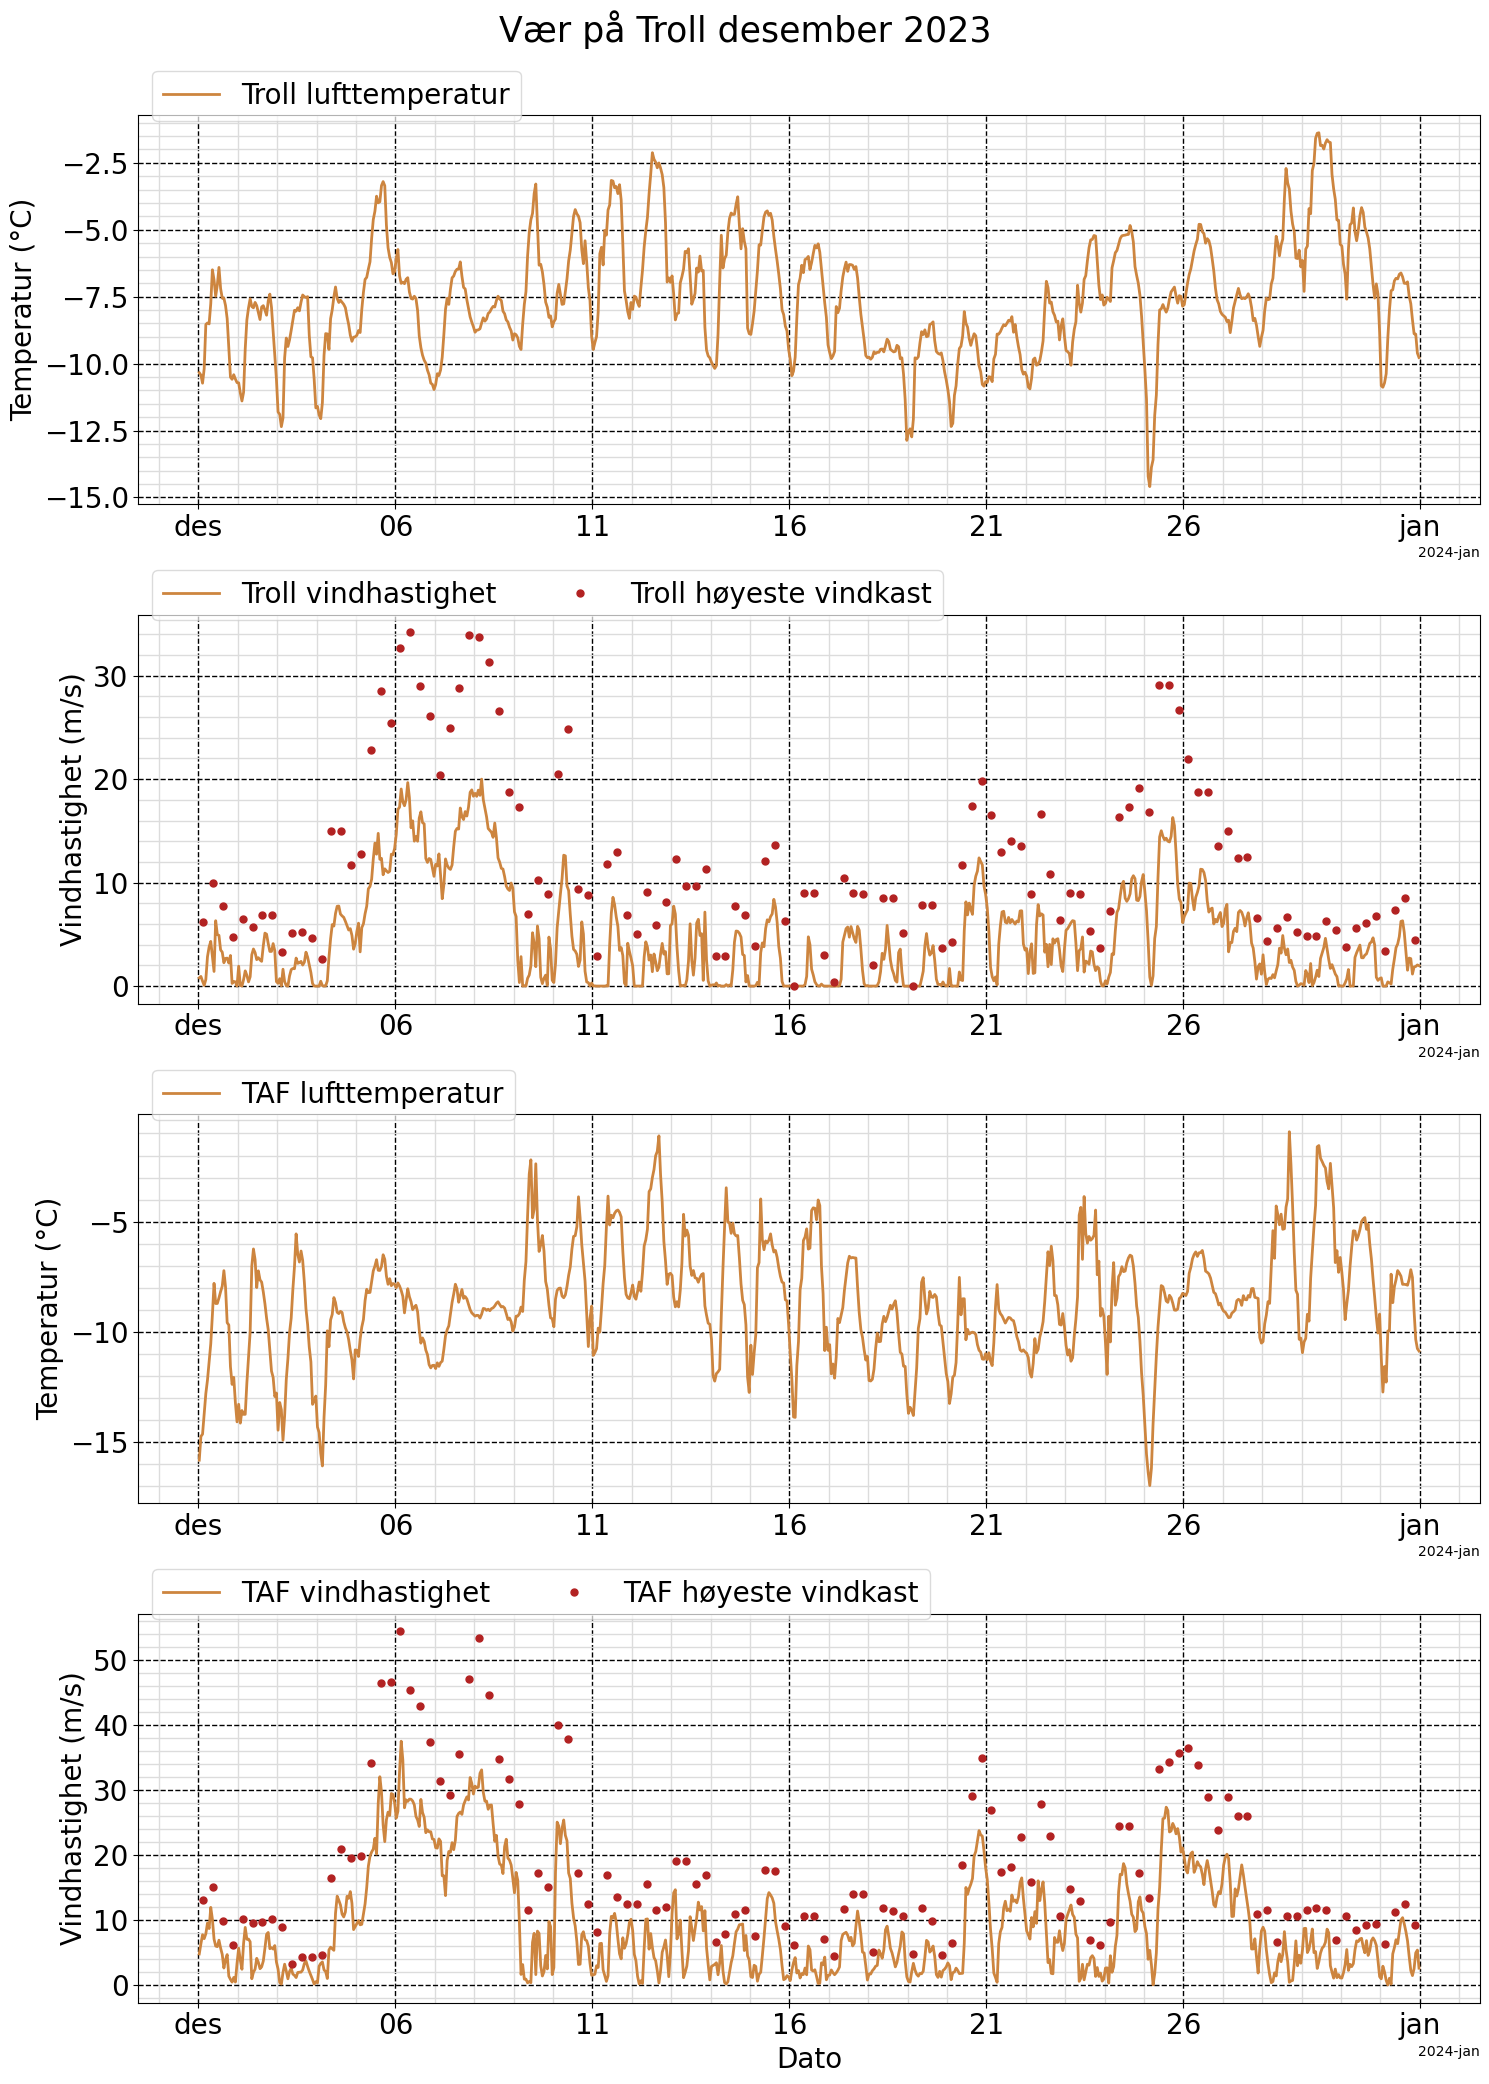

In [6]:
## Use these two lines to get the previous full calendar month
troll = get_data('Troll')
taf   = get_data('TAF')
## OR these four lines to get an arbitrary time period
#start_date = '2021-08-01' #yyyy-mm-dd, full day is included, or yyyy-mm-ddTHH:MM:SS
#end_date   = '2021-09-01' #yyyy-mm-dd, stops at start of day, or yyyy-mm-ddTHH:MM:SS
#troll = get_data('Troll', start_date, end_date)
#taf = get_data('TAF', start_date, end_date)

## Plot 4 panels stacked in portrait orientation, Norwegian text
fig, ax1, ax2, ax3, ax4 = plot_data4(troll, taf, 'nor', 'portrait')
## Plot 4 panels 2x2 in landscape orientation, English text
#fig, ax1, ax2, ax3, ax4 = plot_data4(troll, taf, 'eng', 'landscape')
## Plot 2 panels, Norwegian text
#fig, ax1, ax2 = plot_data2(troll, taf, 'nor')